# 인물사진을 만들어보자.

렌즈를 사용하는 전문가용 카메라와 달리 핸드폰 카메라는 피사체인 인물을 제외한 배경을 흐리게 하는 블러효과를 주기 쉽지 않다.
렌즈를 2개 이상을 탑재하여 인물사진을 만들어 내기도 하는데, 이때 위상차를 이용한다.
하나에 카메라를 이용한 인물사진을 만들어보자.

## 이번 실습 목표
- 하나의 카메라 렌즈로 찍은 사진에서 인물과 사물 및 배경을 구분하는 Sementic segmentation을 적용
- 인물과 그외 사물 및 배경을 구분
- 블러효과 구분해서 적용

## 실습 순서
![얕은 포커스 만드는 순서](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-2.max-800x600_jKvxGUl.png)

In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(462, 738, 3)


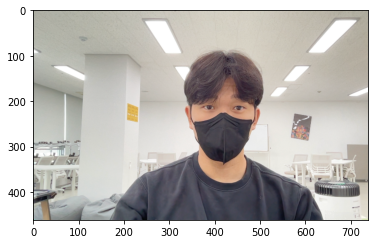

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png' 
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션으로 사람을 분리해보기

포토샵으로 '누끼 따기'라는 것이 원하는 사물을 제외한 이미지를 제거하는 것이다. 그것을 구현해보자.

![사람 분리하기](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-4.max-800x600_9yTzEff.png)

## 이미지 세그멘테이션

이미지에서 픽셀 단위로 라벨을 할당하는 것이 이미지 세그멘테이션이다.

### 종류
#### 시멘틱 세그멘테이션
클래스 단위로 구분하는 것으로 인간, 자전거, 나무 등으로 구분한다.

#### 인스턴스 세그멘테이션
클래스의 객체단위로 구분한다. 인간이면서 1,2,3,4 등과 같이 클래스 안에서도 서로 다른 객체를 구분한다.

![MS COCO datasets의 인스턴스 세그멘테이션](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png)
위의 MS COCO datasets의 인스턴스 세그멘테이션 라벨을 보면 각각의 인물들을 구분해서 분류해주고 있는 걸 확인할 수 있다.

## 딥러닝 기반 이미지 세그멘테이션
### 워터쉐드 세그멘테이션
해발고도에 따라 물이 차면서 해수면이 변화되는데, 이러한 방식으로 경계를 나눠 물체를 구분한다.
![워터쉐드 세그멘테이션 gif](https://opencv-python.readthedocs.io/en/latest/_images/image01.gif)

## 시멘틱 세그멘테이션, DeepLab v3+ 다뤄보기

DeepLab은 v1에서 atrous convolution을 사용하여 세그멘테이션을 발전시켜왔다.
![Atrous convolution](https://bloglunit.files.wordpress.com/2018/07/atrous.png)
위 그림처럼 같은 3x3 크기의 필터를 사용하면서 빈공간 간격을 결정하는 r값에 따라 receptive field를 키울 수 있다.

v2에 와서는 Apatial pyramid pooling 기법으로 feature map에서 r값이 다른 여러 atrous convolution filter를 병렬로 쌓은 후에 합친다. (Concat + 1x1 ConV 등) 위에 Atrous convolution 사진을 처럼 r값이 다른 모양들을 쌓으면 피라미드 모양이 된다.

v3에 와서 픽셀 단위의 정교한 세그멘테이션이 요구될 때, Encoder-Decoder 구조를 사용한다. U-Net이 대표적인 아키텍쳐이며, 생·의학 이미지 세그멘테이션 업무의 핵심으로 자리 잡고 있다.

- Encoder에서 spatial dimension을 줄여가면서 고차원의 semantic 정보를 conolution 필터가 추출해낼 수 있게 되고,
- Decoder에서 spatial dimension 축소로 손실된 spatial정보를 점진적으로 복원하면서보다 정교한 boundary 세그멘테이션을 완성시킨다.

U-Net은 encoder-decoder구조에서 디코딩 하는 과정에서 이전 encoder feature map 중 동일한 크기를 지인 feature map을 가져와 prior로 활용하면서 더 훌륭한 boundary 세그멘테이션을 가능하게 했다.

DeepLab V3+에서 U-Net에서 이전 encoder feature map을 가져와 prior로 활용한 것처럼 intermediate connection을 가지는 encoder-decoder 구조를 적용시켜 정교한 object boundary 예측이 가능해졌다.

## pixellib에서 deepLab의 모델을 가져오자.

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f6a990741c0>)

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

## 분류할 라벨들의 종류를 입력하자

model의 세그먼트 라벨을 pascal voc데이터의 라벨을 불러오자.

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

총 21개의 데이터 라벨이 있다.

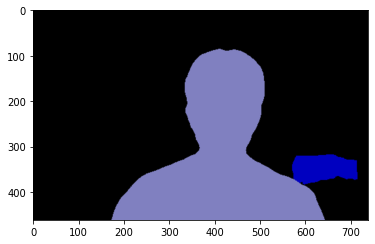

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

아웃풋에는 클래스 아이디별로 색을 픽셀단위로 색을 칠했다.

In [8]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [12]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

### 인물 세그맨테이션 부분을 마스크 필터 만들기

(462, 738)


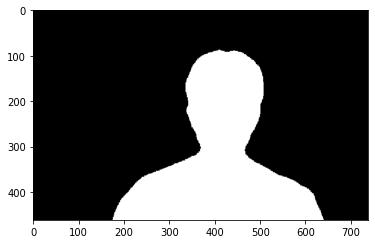

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')

plt.show()

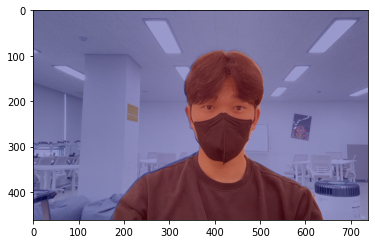

In [14]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

인물 세그멘테이션(빨강)과 그외(배경,파랑)을 투명도를 조절해서 기존 사진과 겹치게 출력했다. 세그멘테이션이 잘 된걸 확인할 수 있다.

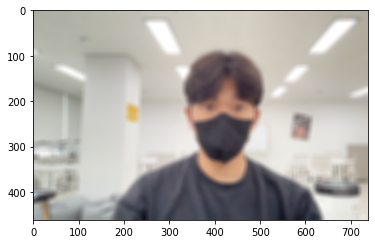

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

13으로도 충분한 블러효과가 나타났다.

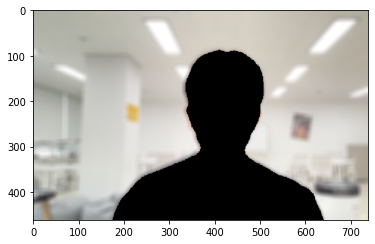

In [16]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
인물 마스크 부분의 색을 지워버렸다.

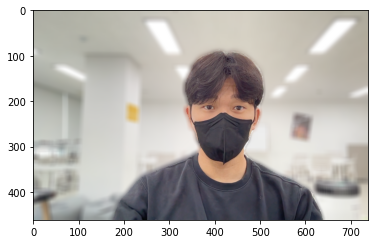

In [17]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

블러 마스크 사진과 마스크의 검정 부분에는 원본사진이 잘 들어갔다.

## 추가 인물사진 만들어보기

이번에는 인물과 대비가 적은 배경과 사물이 있는 경우를 보자.

(462, 738, 3)


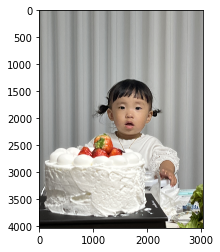

In [18]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
baby_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/baby.jpeg' 
baby_img_orig = cv2.imread(baby_img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(baby_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
segvalues, output = model.segmentAsPascalvoc(baby_img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [20]:
print(output.shape)
print(segvalues.keys())
print(segvalues['masks'].shape)

(3024, 4032, 3)
dict_keys(['class_ids', 'masks'])
(3024, 4032)


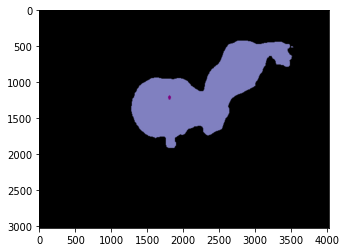

In [21]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

이상하게 새로사진이라 그런지 90도가 돌아가서 출력된다.

np.array.shape는 잘 나오는데 이상하다.

계속 진행해보자.

In [22]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  5, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


사람과 병, 배경을 구분해냈다.

병은 눈동자를 잘못 인식한 듯하다.

In [25]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
baby_img_show = baby_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
baby_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
baby_color_mask = cv2.applyColorMap(baby_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
baby_img_show = cv2.addWeighted(baby_img_show, 0.6, baby_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(baby_img_show, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


90도가 뒤집혀서 차원이 달라 오류가 난듯 하다.

아까 모델을 거쳐서 나올 때 90도로 기울어진 탓인듯 하니 행렬 변환을 통해 사이즈를 맞춰보자.

In [26]:
# seg_map_rotate = cv2.rotate(seg_map, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(cv2.rotate(seg_map, cv2.ROTATE_90_CLOCKWISE))
plt.show()

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'rotate'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


png 파일을 불러와보자.

(462, 738, 3)


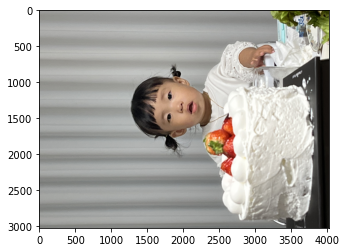

In [27]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
baby_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/baby.png' 
baby_img_orig = cv2.imread(baby_img_path)

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(baby_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

아에 가로로 돌아가있다. png랑 jpeg랑 무슨차이인진 모르겠지만 이런 결과가 나왔다.

(462, 738, 3)


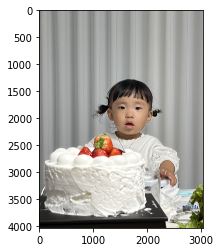

In [28]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
baby_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/baby.png' 
baby_img_orig = cv2.imread(baby_img_path)
baby_img_orig = cv2.rotate(baby_img_orig, cv2.ROTATE_90_CLOCKWISE)

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(baby_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

90도 시계방향으로 회전

In [29]:
segvalues, output = model.segmentAsPascalvoc(baby_img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

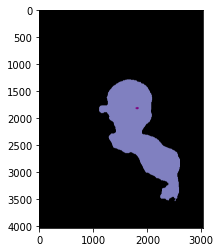

In [30]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(output)
plt.show()

아웃풋도 회전을 시켜 재할당 시켰더니 잘 나온다. 근데 행렬이 전치되서 잘 될지 걱정도 된다.

In [31]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


(4032, 3024)


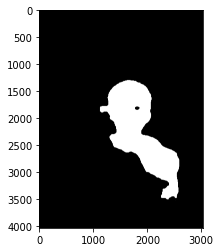

In [32]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

사람으로 인식했을텐데 왜 눈을 병으로 세그멘테이션 한지 모르겠다.

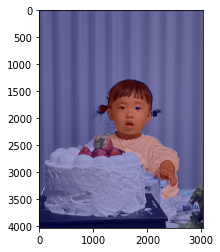

In [33]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
baby_img_show = baby_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
baby_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
baby_color_mask = cv2.applyColorMap(baby_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
baby_img_show = cv2.addWeighted(baby_img_show, 0.6, baby_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(baby_img_show, cv2.COLOR_BGR2RGB))
plt.show()

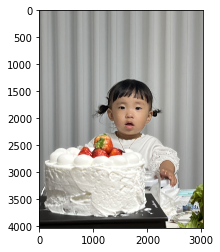

In [34]:
baby_img_orig_blur = cv2.blur(baby_img_orig, (6,6))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(baby_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

왜 인지 블러 효과가 적용되지 않았다.

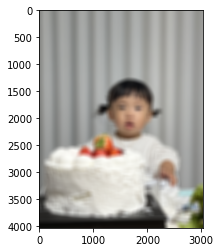

In [66]:
baby_img_orig_blur = cv2.blur(baby_img_orig, (100,100))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(baby_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

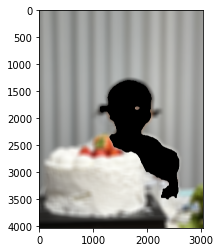

In [36]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
baby_img_mask_color = cv2.cvtColor(baby_img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
baby_img_bg_mask = cv2.bitwise_not(baby_img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
baby_img_bg_blur = cv2.bitwise_and(baby_img_orig_blur, baby_img_bg_mask)
plt.imshow(cv2.cvtColor(baby_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

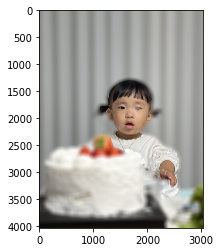

In [37]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
baby_img_concat = np.where(baby_img_mask_color==255, baby_img_orig, baby_img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(baby_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

인물사진이 완성됐다. 평가는 나중에 한번에 해보자.

### 3번쨰 인물사진

가방을 맨 인물의 뒷모습을 보자.

(462, 738, 3)


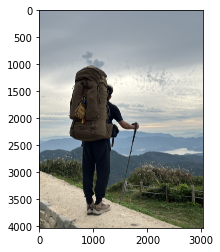

In [38]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
bag_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bag.png' 
bag_img_orig = cv2.imread(bag_img_path)
bag_img_orig = cv2.rotate(bag_img_orig, cv2.ROTATE_90_CLOCKWISE)

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(bag_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

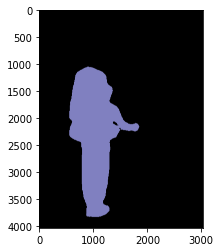

In [39]:
segvalues, output = model.segmentAsPascalvoc(bag_img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(output)
plt.show()

In [40]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


(4032, 3024)


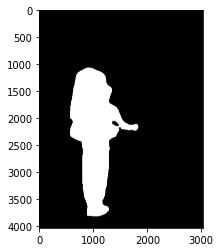

In [41]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

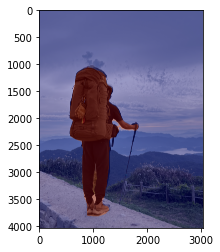

In [42]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
bag_img_show = bag_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
bag_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
bag_color_mask = cv2.applyColorMap(bag_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
bag_img_show = cv2.addWeighted(bag_img_show, 0.6, bag_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(bag_img_show, cv2.COLOR_BGR2RGB))
plt.show()

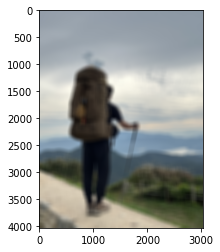

In [43]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
bag_img_orig_blur = cv2.blur(bag_img_orig, (100,100))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(bag_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

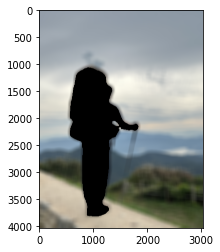

In [44]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
bag_img_mask_color = cv2.cvtColor(bag_img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
bag_img_bg_mask = cv2.bitwise_not(bag_img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
bag_img_bg_blur = cv2.bitwise_and(bag_img_orig_blur, bag_img_bg_mask)
plt.imshow(cv2.cvtColor(bag_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

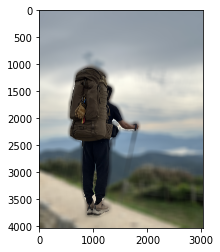

In [45]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
bag_img_concat = np.where(bag_img_mask_color==255, bag_img_orig, bag_img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(bag_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 강아지 해보기

(462, 738, 3)


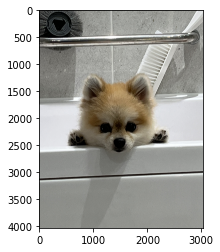

In [46]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
dog_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png' 
dog_img_orig = cv2.imread(dog_img_path)
dog_img_orig = cv2.rotate(dog_img_orig, cv2.ROTATE_90_CLOCKWISE)

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

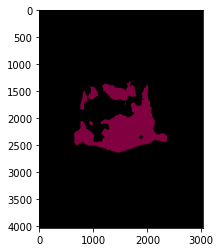

In [52]:
segvalues, output = model.segmentAsPascalvoc(dog_img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(output)
plt.show()

In [48]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


dog라는 class를 세그멘테이션 해주기 위해서 컬러맵을 확인해서 seg_color를 변경해주자.

In [53]:
colormap[12] #컬러맵 12에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([ 64,   0, 128])

In [56]:
seg_color = (128,0,64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(4032, 3024)


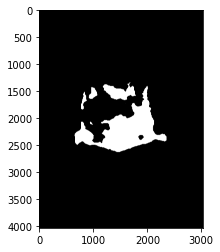

In [57]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

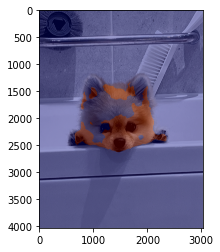

In [58]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
dog_img_show = dog_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
dog_img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
dog_color_mask = cv2.applyColorMap(dog_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
dog_img_show = cv2.addWeighted(dog_img_show, 0.6, dog_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

강아지 얼굴을 명확하게 구분해내지 못했다.

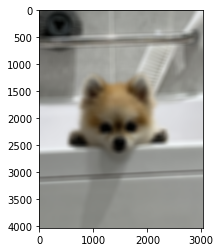

In [60]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
dog_img_orig_blur = cv2.blur(dog_img_orig, (100,100))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(dog_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

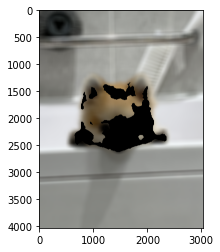

In [61]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
dog_img_mask_color = cv2.cvtColor(dog_img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
dog_img_bg_mask = cv2.bitwise_not(dog_img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
dog_img_bg_blur = cv2.bitwise_and(dog_img_orig_blur, dog_img_bg_mask)
plt.imshow(cv2.cvtColor(dog_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

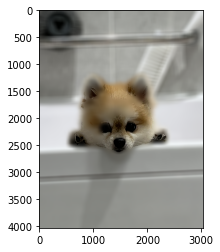

In [63]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
dog_img_concat = np.where(dog_img_mask_color==255, dog_img_orig, dog_img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

그래도 눈,코,입 등의 이목구비는 비교적 정확하게 표현되었다.

# 인물사진 문제점 찾아보기

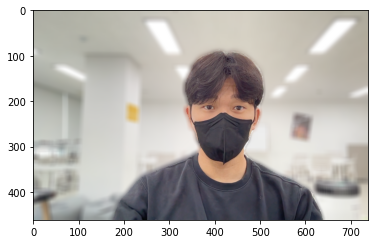
처음 인물사진으로 찍어본 사진은 아주 훌륭한 결과물이었다. 우선 검은 옷으로 입었고 흰색 배경이랑 대비되어 좀 더 세그멘테이션에 유리 했던거 같다.

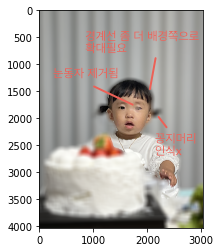
- 왼쪽 눈의 눈동자를 구분하지 못했고
- 머리카락과 커튼 사이 경계선이 머리카락 안쪽으로 구획되어서 머리카락이 일부 블러처리되었다.
- 꽁지머리 하나가 인물로 인식되어지지 못했다.

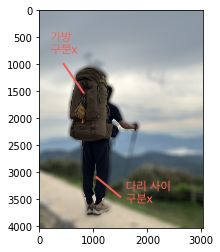
- 가방을 구분해내지 못했다. pascal vos에 라벨로 포함되지 않아서 그런 것 같다.
- 다리 사이 너머로 찍혀진 배경같이 조그만 부분을 세그멘테이션하는데 실패했다.

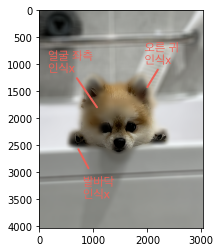
- 강아지로 구획은 되었지만 얼굴의 절반정도만 인식해서, 인식율이 제일 낮았다.
- 발바닥 한쪽을 인식하지 못했고
- 얼굴의 1/3은 인식을 못하고
- 귀도 하나 고양이로 인식하지 못했다.

# 회고

세그멘테이션 중 시멘틱 세그멘테이션을 경험해봤는데, 간단하게 라이브러리에서 모델을 가져와서 적용하는데도 놀라운 성능을 보여줬다.
개선할 수 있는 방법도 분명히 있어보이는데, 다양한 시도를 해보지 못한 점은 좀 아쉽다.

그리고 세그멘테이션 라벨이 21가지 밖에 안되는 점은 좀 아쉽다.
더 많은 라벨이 있는 세그멘테이션을 한번 찾아봐야겠다.

실제로 간단하게라도 세그멘테이션 사전 학습한 모델을 만들어보면 좋겠다.